In [1]:
# import necessary libraries
import os
import boto3
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

import splitfolders

from keras.preprocessing.image import ImageDataGenerator

from keras import layers
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications import MobileNet, EfficientNetV2B0, DenseNet121, ResNet50

from keras.layers import Dense, GlobalAveragePooling2D
from config import aws_access_key_id, aws_secret_access_key

## Data collection

In [4]:
# Set your AWS credentials and region
aws_access_key_id=aws_access_key_id,
aws_secret_access_key=aws_secret_access_key,
region_name = "us-east-2"
bucket_name = "capstone-pill-images"
data_prefix = "data/data"


# Create an S3 client
s3 = boto3.client(
    's3',
     aws_access_key_id=aws_access_key_id,
     aws_secret_access_key=aws_secret_access_key,
     region_name=region_name
    )

In [5]:

# Function to download images from S3 bucket to a local directory with subdirectories
def download_images_from_s3(bucket_name, prefix, local_directory):
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    for obj in response.get('Contents', []):
        key = obj['Key']

        # Extract the drug name from the key
        # Split the key at the second "/" to get the correct drug name

    for obj in response.get('Contents', []):
        key = obj['Key']
        local_path = os.path.join(local_directory, os.path.relpath(key, prefix))  # Use os.path.relpath to get the relative path
        os.makedirs(os.path.dirname(local_path), exist_ok=True)  # Create intermediate directories if they don't exist
        s3.download_file(bucket_name, key, local_path)





In [6]:
# Download training images
local_drug_directory = "local_drug_directory"
# download_images_from_s3(bucket_name, data_prefix, local_drug_directory)


In [ ]:
# to convert images to arrays

# subdirectories = [d for d in os.listdir(local_drug_directory) if os.path.isdir(os.path.join(local_drug_directory, d))]

# # Collect all image files from all subdirectories
# all_image_files = []
# for subdirectory in subdirectories:
#     subdirectory_path = os.path.join(local_drug_directory, subdirectory)

#     # List all image files in the subdirectory
#     image_files = [f for f in os.listdir(subdirectory_path) if f.lower().endswith(('.jpg', '.jpeg'))]

#     # Add the image files to the combined list
#     all_image_files.extend(os.path.join(subdirectory_path, f) for f in image_files)
    
# random.shuffle(all_image_files)

# number_of_img = 5


# for i in range(number_of_img):
    
#     random_image_file = all_image_files.pop()
    
#     image = mpimg.imread(random_image_file)
    
#     np.expand_dims(image, axis=0)
    
#     image = image/225

## Display sample images

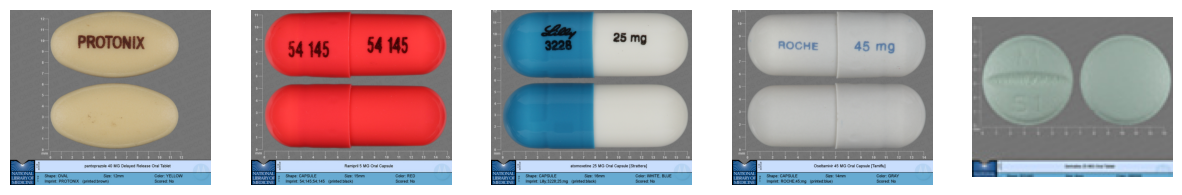

In [5]:
def show_sample_images(local_directory):
    # Go into the local directory and put all subdirectories in a List
    subdirectories = [d for d in os.listdir(local_directory) if os.path.isdir(os.path.join(local_directory, d))]

    # Check if there are any subdirectories
    if not subdirectories:
        print("No subdirectories found in the directory.")
        return

    # Collect all image files from all subdirectories
    all_image_files = []
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(local_directory, subdirectory)

        # List all image files in the subdirectory
        image_files = [f for f in os.listdir(subdirectory_path) if f.lower().endswith(('.jpg', '.jpeg'))]

        # Add the image files to the combined list
        all_image_files.extend(os.path.join(subdirectory_path, f) for f in image_files)

    # Shuffle the combined list of image files
    random.shuffle(all_image_files)

    # Set the number of random images to display
    num_images_to_display = 5

    # Create subplots to display images side by side
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))  # Adjust figsize as needed
    
    # Loop to select and display 5 random images
    for i in range(num_images_to_display):
        # Check if there are still image files available
        if not all_image_files:
            break

        # Pop a random image from the combined list
        random_image_file = all_image_files.pop()

        # Load and display the randomly selected image
        img = mpimg.imread(random_image_file)

        # Display the image in the subplot
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis labels
        
       

    # Show the subplots
    plt.show()

# Example usage
show_sample_images(local_drug_directory)

## preprocess the image data

In [6]:
# define loading parameters
img_height = 224
img_width = 224
batch_size = 1

In [7]:
# split the downloaded image folder into train, validation and test folders
# splitfolders.ratio('local_drug_directory', output="output", seed=1337, ratio=(.8, 0.1,0.1)) 

In [8]:
# rescale the images
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# define paths for directories
train_dir = "output/train/"
valid_dir = "output/val/"

In [10]:
# using ImageDataGenerator and flow_from_directory to preprocess the images
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_width,img_height),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode="categorical"
                                                   )

Found 437 images belonging to 23 classes.


In [11]:
# using ImageDataGenerator and flow_from_directory to preprocess the images
validation_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(img_width,img_height),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode="categorical"
                                                   )

Found 46 images belonging to 23 classes.


In [12]:
# to extract the class names for label
class_names = train_generator.class_indices.keys()
class_names

dict_keys(['Amoxicillin 500 mg', 'Apixaban 2.5 mg', 'Aprepitant 80 mg', 'Atomoxetine 25 mg', 'Calcitriol 0.00025', 'Prasugrel 10 MG', 'Ramipril 5 MG', 'Saxagliptin 5 MG', 'Sitagliptin 50 MG', 'Tadalafil 5 MG', 'carvedilol 3.125', 'celecoxib 200', 'duloxetine 30', 'eltrombopag 25', 'metformin_500', 'montelukast-10', 'mycophenolate-250', 'omeprazole_40', 'oseltamivir-45', 'pantaprazole-40', 'pitavastatin_1', 'prednisone_5', 'sertraline_25'])

-------
## Model Optimization
-------

In [13]:
# function to load then model with non-trainable params
def base_model_optimizer(model_name):
    base_model_optimizer = model_name(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model_optimizer.trainable = False
    return base_model_optimizer


In [14]:
# pass the model name to base_model function
VGG16 = base_model_optimizer(VGG16)
RestNet50 = base_model_optimizer(ResNet50)
MobileNet = base_model_optimizer(MobileNet)
EfficientNetV2B0 = base_model_optimizer(EfficientNetV2B0)
DenseNet121 = base_model_optimizer(DenseNet121)

In [15]:
# add the base model to a list
base_models = []
base_models.append(('VGG16',VGG16))
base_models.append(('RestNet50',RestNet50))
base_models.append(('EfficientNetV2B0',EfficientNetV2B0))
base_models.append(('DenseNet121',DenseNet121))
base_models.append(('MobileNet',MobileNet))

In [16]:
# empty lists for storing model name, model loss and model accuracy
names = []
accuracy = []
loss = []

# loop through base model to load the base model into our Sequential model
for name, base_model in base_models:
    model = Sequential()
    
    # add base model to Sequential 
    model.add(base_model)
    # add GlobalAveragePooling2D to 2nd layer
    model.add(GlobalAveragePooling2D())
    # add 23 neurons to output layer and softmax as activation
    model.add(Dense(23, activation="softmax"))
    model.summary()
    
    # compile the model
    model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])
    
    # fit the model to training data
    model.fit(train_generator, epochs=2, validation_data = validation_generator)
    
    # evaluate with validation data
    model_loss, model_accuracy = model.evaluate(validation_generator, verbose=2)
    
    # append the empty lists with respective values
    loss.append(model_loss)
    accuracy.append(model_accuracy)
    names.append(name)

# return a dataframe
df = pd.DataFrame({'Name': names, 
                   'Accuracy' : accuracy, 
                   'Loss' : loss})
    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 23)                11799     
                                                                 
Total params: 14726487 (56.18 MB)
Trainable params: 11799 (46.09 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/2
437/437 [==============================] - 172s 392ms/step - loss: 2.8505 - accuracy: 0.2014 - val_loss: 2.2849 - val_accuracy: 0.3696
Epoch 2/2
437/437 [==============================] - 175s 400ms/

In [18]:
df

,Name,Accuracy,Loss
0,VGG16,0.913043,1.635550
1,RestNet50,0.043478,3.215039
2,EfficientNetV2B0,0.043478,3.395020
3,DenseNet121,1.000000,0.093723
4,MobileNet,1.000000,0.022115
